# Preprocesamiento de Datos – ASTRO vs DM

## Separación de Datos ASTRO y DM para Modelado One-Class SVM

El archivo original `XY_bal_log_Rel.txt` contiene un conjunto de datos etiquetado, en el cual las instancias se clasifican como:

- **0 (ASTRO)**: fuentes astrofísicas reales, identificadas por telescopios.
- **1 (DM)**: fuentes simuladas que imitan la señal esperada de materia oscura (Dark Matter).

El dataset también contiene las siguientes variables (features):

1. `Log(E_peak)`: Logaritmo del pico de energía del espectro gamma.
2. `Log(beta)`: Logaritmo de la curvatura espectral.
3. `Log(sigma)`: Logaritmo de la significancia de detección.
4. `Log(beta_Rel)`: Logaritmo del error relativo de `beta`.

---

### 🎯 Objetivo del preprocesamiento

El propósito principal de este notebook es preparar los datos para entrenar un modelo **One-Class SVM**, el cual está diseñado para aprender únicamente a partir de ejemplos de una sola clase, considerada "normal". En este caso:

> Se considera que las fuentes ASTRO representan el comportamiento normal observable en el espacio gamma.

Por tanto, se decide **separar el dataset original en dos subconjuntos distintos**:

- Un archivo que contiene exclusivamente fuentes ASTRO (`astro_DM == 0`), que será usado para el entrenamiento del modelo.
- Otro archivo que contiene las simulaciones de materia oscura (`astro_DM == 1`), que será reservado para futuras fases de evaluación del modelo.

---

### ⚙️ Procedimiento aplicado

1. Se cargó el dataset original con nombres de columnas definidos manualmente.
2. Se verificó la distribución de clases y se confirmó que los datos estaban correctamente etiquetados.
3. Se dividieron los datos en dos nuevos DataFrames: `astro_df` y `dm_df`.
4. Ambos subconjuntos se guardaron en rutas separadas para su posterior reutilización:

- `data/processed/XY_bal_log_Rel/astro/XY_bal_log_Rel_astro.txt`
- `data/processed/XY_bal_log_Rel/DM/XY_bal_log_Rel_DM.txt`

---

### ✅ Justificación metodológica

Separar las clases desde el preprocesamiento tiene varias ventajas:

- Permite un entrenamiento limpio del One-Class SVM con datos puramente normales.
- Evita introducir sesgos derivados de simulaciones (DM) en la fase de entrenamiento.
- Establece un flujo de datos reproducible y controlado, ideal para procesos de validación y experimentación.

Este enfoque está alineado con el objetivo general del trabajo: identificar potenciales señales de materia oscura a través de la detección de anomalías en fuentes no identificadas (unIDs), partiendo de un modelo entrenado únicamente con datos astrofísicos reales.


In [204]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [205]:
# Leer archivo desde ruta relativa a la raíz del proyecto
file_path = '../../data/raw/XY_bal_log_Rel.txt'

# Leer archivo con nombres de columnas
columnas = ['Log(E_peak)', 'Log(beta)', 'Log(sigma)', 'Log(beta_Rel)', 'astro_DM']
df = pd.read_csv(file_path, sep='\s+', header=0, names=columnas)

In [206]:
df.head()

,Log(E_peak),Log(beta),Log(sigma),Log(beta_Rel),astro_DM
0,-0.412502,-1.325139,1.356951,-0.122193,0.0
1,0.708140,-0.000174,0.623167,-1.601886,0.0
2,0.224740,-0.581202,1.010041,-0.311249,0.0
3,0.257319,-0.561933,0.615413,-0.038913,0.0
4,0.326110,-1.100179,1.624932,-0.528753,0.0


In [207]:
df.shape


(5662, 5)

In [208]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5662 entries, 0 to 5661
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Log(E_peak)    5662 non-null   float64
 1   Log(beta)      5662 non-null   float64
 2   Log(sigma)     5662 non-null   float64
 3   Log(beta_Rel)  5662 non-null   float64
 4   astro_DM       5662 non-null   float64
dtypes: float64(5)
memory usage: 221.3 KB


In [209]:
# Distribución de clases
print(df['astro_DM'].value_counts())


astro_DM
0.0    2831
1.0    2831
Name: count, dtype: int64


In [210]:
# Estadísticas por clase
print(df.groupby('astro_DM').describe())

         Log(E_peak)                                                    \
               count      mean       std       min       25%       50%   
astro_DM                                                                 
0.0           2831.0 -0.086668  1.280269 -5.912006 -0.683526  0.008004   
1.0           2831.0  2.123150  1.218007 -0.382580  1.200577  2.228400   

                             Log(beta)            ... Log(sigma)            \
               75%       max     count      mean  ...        75%       max   
astro_DM                                          ...                        
0.0       0.689384  5.918502    2831.0 -0.935025  ...   1.328710  2.899104   
1.0       3.160619  4.035430    2831.0 -0.703099  ...   1.181844  2.668479   

         Log(beta_Rel)                                                    \
                 count      mean       std       min       25%       50%   
astro_DM                                                                   
0.0       

In [211]:
# Ver estadísticas generales (valores mínimos, máximos, media, desviación estandar, etc.)
print("Estadísticas descriptivas:")
df.describe()

Estadísticas descriptivas:


,Log(E_peak),Log(beta),Log(sigma),Log(beta_Rel),astro_DM
count,5662.000000,5662.000000,5662.000000,5662.000000,5662.000000
mean,1.018241,-0.819062,1.061131,-0.061574,0.500000
std,1.667957,0.413740,0.357026,0.478845,0.500044
min,-5.912006,-2.602060,0.608098,-3.198657,0.000000
25%,-0.086760,-1.093827,0.778414,-0.301915,0.000000
50%,0.883369,-0.805070,0.973677,-0.045029,0.500000
75%,2.302818,-0.502967,1.254676,0.287035,1.000000
max,5.918502,0.000000,2.899104,1.866966,1.000000


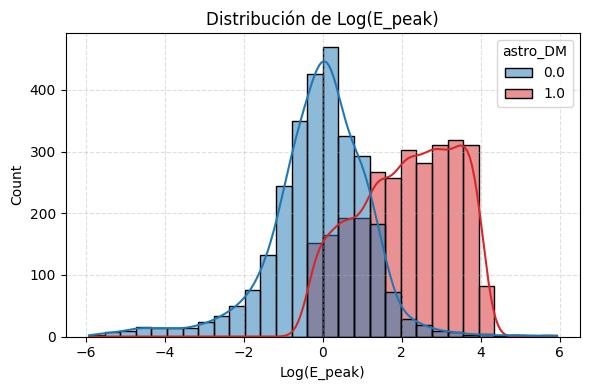

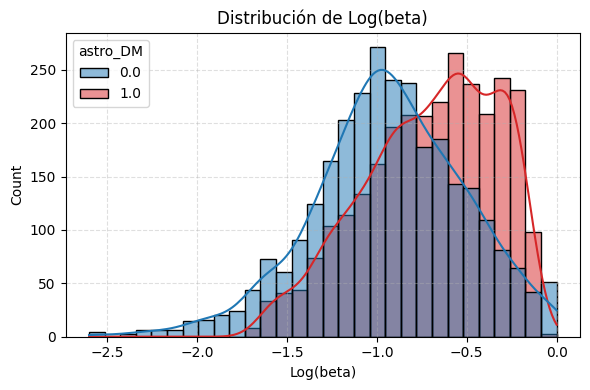

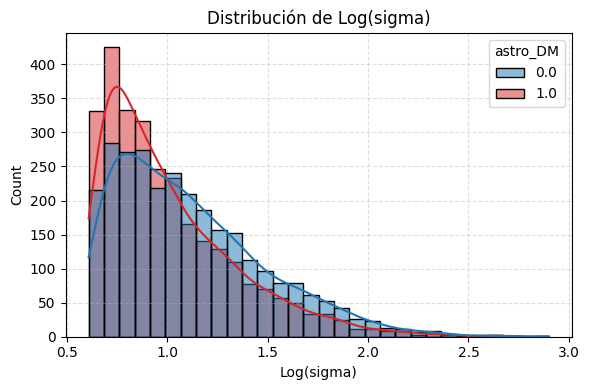

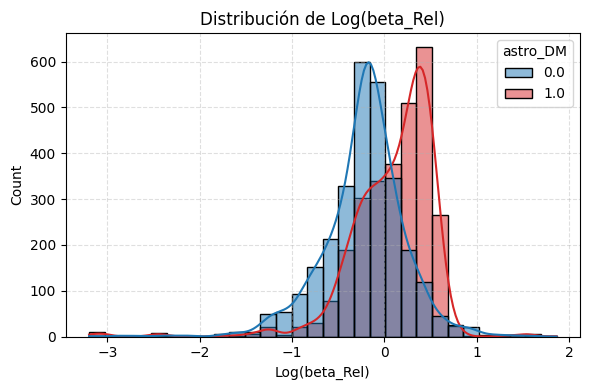

In [212]:
# Histograma por feature y clase
# Definir paleta personalizada
custom_palette = {
    0: '#1f77b4',  # Azul (ASTRO)
    1: '#d62728'   # Rojo (DM)
}

# Histograma por feature y clase
for col in df.columns[:-1]:  # sin la columna de clase
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x=col, hue='astro_DM', kde=True, bins=30, palette=custom_palette)
    plt.title(f'Distribución de {col}')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


In [213]:
# Separar en Astro y DM
astro_df = df[df['astro_DM'] == 0]
dm_df = df[df['astro_DM'] == 1]

# Conservar la columna de clase
astro_df = astro_df[['Log(E_peak)', 'Log(beta)', 'Log(sigma)', 'Log(beta_Rel)', 'astro_DM']]
dm_df = dm_df[['Log(E_peak)', 'Log(beta)', 'Log(sigma)', 'Log(beta_Rel)', 'astro_DM']]

# Maantener la primera fila de cada dataframe con el nombre de los features
astro_df.columns = ['Log(E_peak)', 'Log(beta)', 'Log(sigma)', 'Log(beta_Rel)', 'astro_DM']
dm_df.columns = ['Log(E_peak)', 'Log(beta)', 'Log(sigma)', 'Log(beta_Rel)', 'astro_DM']

# Guardar los dataframes separados en archivos CSV
astro_df.to_csv('../../data/processed/XY_bal_log_Rel/astro/astro_df.csv', index=False)
dm_df.to_csv('../../data/processed/XY_bal_log_Rel/DM/dm_df.csv', index=False)

# Lo guardamos también como txt
astro_df.to_csv('../../data/processed/XY_bal_log_Rel/astro/astro_df.txt', sep='\t', index=False)
dm_df.to_csv('../../data/processed/XY_bal_log_Rel/DM/dm_df.txt', sep='\t', index=False)

# Comprobar si los dataframes se han guardado correctamente
astro_df_check = pd.read_csv('../../data/processed/XY_bal_log_Rel/astro/astro_df.csv')
dm_df_check = pd.read_csv('../../data/processed/XY_bal_log_Rel/DM/dm_df.csv')



In [214]:

# Comprobar distrbución de los dataframes individuales
print("Distribución de Astro:")
print(astro_df_check.shape)
print("Distribución de DM:")
print(dm_df_check.shape)

Distribución de Astro:
(2831, 5)
Distribución de DM:
(2831, 5)


In [215]:
print("Cabecera de Astro:")
astro_df_check.head()

Cabecera de Astro:


,Log(E_peak),Log(beta),Log(sigma),Log(beta_Rel),astro_DM
0,-0.412502,-1.325139,1.356951,-0.122193,0.0
1,0.708140,-0.000174,0.623167,-1.601886,0.0
2,0.224740,-0.581202,1.010041,-0.311249,0.0
3,0.257319,-0.561933,0.615413,-0.038913,0.0
4,0.326110,-1.100179,1.624932,-0.528753,0.0


In [216]:
print("Cabecera de DM:")
dm_df_check.head()

Cabecera de DM:


,Log(E_peak),Log(beta),Log(sigma),Log(beta_Rel),astro_DM
0,2.518909,-0.313990,0.987488,0.528569,1.0
1,1.922881,-0.659556,1.345178,0.395713,1.0
2,2.463445,-0.534617,0.792322,0.288124,1.0
3,2.571126,-1.246647,0.694254,0.447771,1.0
4,1.386499,-0.951947,1.098990,-0.412871,1.0


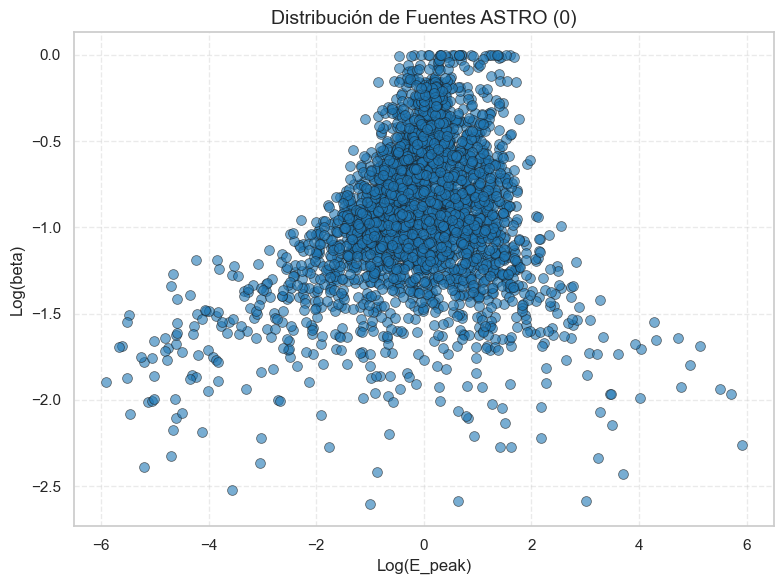

In [217]:
plt.figure(figsize=(8, 6))
sns.set(style='whitegrid')

sns.scatterplot(
    data=astro_df_check,
    x='Log(E_peak)',
    y='Log(beta)',
    color='#1f77b4',          # Azul clásico
    edgecolor='k',
    s=50,
    alpha=0.6
)

plt.title('Distribución de Fuentes ASTRO (0)', fontsize=14)
plt.xlabel('Log(E_peak)', fontsize=12)
plt.ylabel('Log(beta)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [218]:
print("Cabecera de DM:")
dm_df.head()

Cabecera de DM:


,Log(E_peak),Log(beta),Log(sigma),Log(beta_Rel),astro_DM
2831,2.518909,-0.313990,0.987488,0.528569,1.0
2832,1.922881,-0.659556,1.345178,0.395713,1.0
2833,2.463445,-0.534617,0.792322,0.288124,1.0
2834,2.571126,-1.246647,0.694254,0.447771,1.0
2835,1.386499,-0.951947,1.098990,-0.412871,1.0


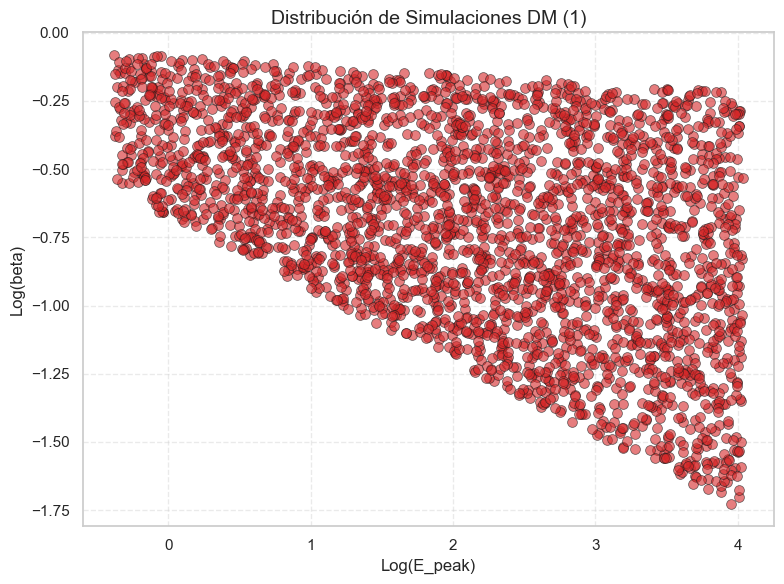

In [219]:
plt.figure(figsize=(8, 6))
sns.set(style='whitegrid')

sns.scatterplot(
    data=dm_df_check,
    x='Log(E_peak)',
    y='Log(beta)',
    color='#d62728',          # Rojo intenso
    edgecolor='k',
    s=50,
    alpha=0.6
)

plt.title('Distribución de Simulaciones DM (1)', fontsize=14)
plt.xlabel('Log(E_peak)', fontsize=12)
plt.ylabel('Log(beta)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


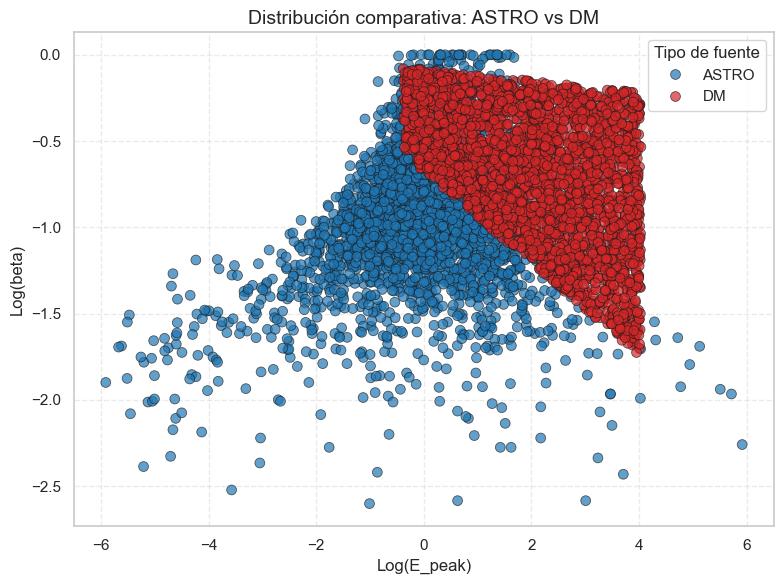

In [220]:
combined_df = pd.concat([astro_df_check.assign(tipo='ASTRO'), dm_df_check.assign(tipo='DM')])

palette = {
    'ASTRO': '#1f77b4',
    'DM': '#d62728'
}

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=combined_df,
    x='Log(E_peak)',
    y='Log(beta)',
    hue='tipo',
    palette=palette,
    edgecolor='k',
    alpha=0.7,
    s=50
)
plt.title('Distribución comparativa: ASTRO vs DM', fontsize=14)
plt.xlabel('Log(E_peak)', fontsize=12)
plt.ylabel('Log(beta)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(title='Tipo de fuente')
plt.tight_layout()
plt.show()
